# Speech emotion recognition using 1-dimensional ConvNN

In this experiment i tried to recognize emotion in short voice message (< 3s). I will use 4 datasets with some english phrases,
which were voiced by professional actors: Ravee, Crema, Savee and Tess.

#### First, lets define SER i.e. Speech Emotion Recognition.

*Speech Emotion Recognition*, abbreviated as *SER*, is the act of attempting to recognize human emotion and affective states from speech.
This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon
that animals like dogs and horses employ to be able to understand human emotion

**Datasets used in this project** contains ~7 types of main emotions: *Happy, Fear, Angry, Disgust, Surprised, Sad or Neutral.*

Also, my thanks to [this notebook](https://www.kaggle.com/shivamburnwal/speech-emotion-recognition) which helps me to start very much. 

So, let's start!

## Importing libraries

In [4]:
import os
import re

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
# from entropy import spectral_entropy
from keras import layers
from keras import models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import itertools

In [5]:
# Paths to
Ravdess = "ser-datasets\Ravdess"
Crema = "ser-datasets\Crema"
Savee = "ser-datasets\Savee"
Tess = "ser-datasets\Tess"

## Data preparation

### Ravdess dataset

Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [6]:
import os

Ravdess = "ser-datasets\Ravdess"

ravdess_directory_list = os.listdir(Ravdess)
print(f"Processing directory: {Ravdess}")

emotion_df = []
for dir in ravdess_directory_list:
    dir_path = os.path.join(Ravdess, dir)

    if not os.path.isdir(dir_path):  
        continue

    actor_files = os.listdir(dir_path)

    for wav in actor_files:
        if not wav.endswith(".wav"): 
            print(f"Skipping {wav}, not a .wav file.")
            continue

        info = wav.partition(".wav")[0].split("-") 
        
        if len(info) < 3:  
            print(f"Skipping {wav}, filename format incorrect: {info}")
            continue
        
        try:
            emotion = int(info[2]) 
            emotion_df.append((emotion, os.path.join(dir_path, wav)))
        except ValueError as e:
            print(f"Error converting emotion from {wav}: {e}")

Processing directory: ser-datasets\Ravdess
Skipping Actor_01, not a .wav file.
Skipping Actor_02, not a .wav file.
Skipping Actor_03, not a .wav file.
Skipping Actor_04, not a .wav file.
Skipping Actor_05, not a .wav file.
Skipping Actor_06, not a .wav file.
Skipping Actor_07, not a .wav file.
Skipping Actor_08, not a .wav file.
Skipping Actor_09, not a .wav file.
Skipping Actor_10, not a .wav file.
Skipping Actor_11, not a .wav file.
Skipping Actor_12, not a .wav file.
Skipping Actor_13, not a .wav file.
Skipping Actor_14, not a .wav file.
Skipping Actor_15, not a .wav file.
Skipping Actor_16, not a .wav file.
Skipping Actor_17, not a .wav file.
Skipping Actor_18, not a .wav file.
Skipping Actor_19, not a .wav file.
Skipping Actor_20, not a .wav file.
Skipping Actor_21, not a .wav file.
Skipping Actor_22, not a .wav file.
Skipping Actor_23, not a .wav file.
Skipping Actor_24, not a .wav file.


In [7]:
Ravdess_df = pd.DataFrame.from_dict(emotion_df)
Ravdess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

In [8]:
import pandas as pd

print("Columns in DataFrame:", Ravdess_df.columns)

Ravdess_df.columns = Ravdess_df.columns.str.strip()

if "emotion" in Ravdess_df.columns:
    col_name = "emotion"
elif "Emotion" in Ravdess_df.columns:
    col_name = "Emotion"
else:
    print("❌ Error: 'emotion' column not found!")
    print("Columns available:", Ravdess_df.columns)
    col_name = None

if col_name:
    Ravdess_df[col_name].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad',
                                  5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

print(Ravdess_df.head())


Columns in DataFrame: Index([], dtype='object')
❌ Error: 'emotion' column not found!
Columns available: Index([], dtype='object')
Empty DataFrame
Columns: []
Index: []


### Crema dataset

In [9]:
emotion_df = []

for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + "/" + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + "/" + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + "/" + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + "/" + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + "/" + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + "/" + wav))
    else:
        emotion_df.append(("unknown", Crema + "/" + wav))


Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Crema_df.head()

,Emotion,Path
0,angry,ser-datasets\Crema/1001_DFA_ANG_XX.wav
1,disgust,ser-datasets\Crema/1001_DFA_DIS_XX.wav
2,fear,ser-datasets\Crema/1001_DFA_FEA_XX.wav
3,happy,ser-datasets\Crema/1001_DFA_HAP_XX.wav
4,neutral,ser-datasets\Crema/1001_DFA_NEU_XX.wav


### TESS dataset

In [10]:
tess_directory_list = os.listdir(Tess)

emotion_df = []

for dir in tess_directory_list:
    for wav in os.listdir(os.path.join(Tess, dir)):
        info = wav.partition(".wav")[0].split("_")
        emo = info[2]
        if emo == "ps":
            emotion_df.append(("surprise", os.path.join(Tess, dir, wav)))
        else:
            emotion_df.append((emo, os.path.join(Tess, dir, wav)))


Tess_df = pd.DataFrame.from_dict(emotion_df)
Tess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Tess_df.head()

,Emotion,Path
0,angry,ser-datasets\Tess\OAF_angry\OAF_back_angry.wav
1,angry,ser-datasets\Tess\OAF_angry\OAF_bar_angry.wav
2,angry,ser-datasets\Tess\OAF_angry\OAF_base_angry.wav
3,angry,ser-datasets\Tess\OAF_angry\OAF_bath_angry.wav
4,angry,ser-datasets\Tess\OAF_angry\OAF_bean_angry.wav


### Savee dataset

The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [11]:
savee_directiory_list = os.listdir(Savee)

emotion_df = []

for wav in savee_directiory_list:
    info = wav.partition(".wav")[0].split("_")[1].replace(r"[0-9]", "")
    emotion = re.split(r"[0-9]", info)[0]
    if emotion=='a':
        emotion_df.append(("angry", Savee + "/" + wav))
    elif emotion=='d':
        emotion_df.append(("disgust", Savee + "/" + wav))
    elif emotion=='f':
        emotion_df.append(("fear", Savee + "/" + wav))
    elif emotion=='h':
        emotion_df.append(("happy", Savee + "/" + wav))
    elif emotion=='n':
        emotion_df.append(("neutral", Savee + "/" + wav))
    elif emotion=='sa':
        emotion_df.append(("sad", Savee + "/" + wav))
    else:
        emotion_df.append(("surprise", Savee + "/" + wav))


Savee_df = pd.DataFrame.from_dict(emotion_df)
Savee_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Savee_df.head()

,Emotion,Path
0,angry,ser-datasets\Savee/DC_a01.wav
1,angry,ser-datasets\Savee/DC_a02.wav
2,angry,ser-datasets\Savee/DC_a03.wav
3,angry,ser-datasets\Savee/DC_a04.wav
4,angry,ser-datasets\Savee/DC_a05.wav


In [12]:
# Let's concat all datasets together for doing some analysis
df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
df.shape

(10722, 2)

In [13]:
df.head(10)

,Emotion,Path
0,angry,ser-datasets\Crema/1001_DFA_ANG_XX.wav
1,disgust,ser-datasets\Crema/1001_DFA_DIS_XX.wav
2,fear,ser-datasets\Crema/1001_DFA_FEA_XX.wav
3,happy,ser-datasets\Crema/1001_DFA_HAP_XX.wav
4,neutral,ser-datasets\Crema/1001_DFA_NEU_XX.wav
5,sad,ser-datasets\Crema/1001_DFA_SAD_XX.wav
6,angry,ser-datasets\Crema/1001_IEO_ANG_HI.wav
7,angry,ser-datasets\Crema/1001_IEO_ANG_LO.wav
8,angry,ser-datasets\Crema/1001_IEO_ANG_MD.wav
9,disgust,ser-datasets\Crema/1001_IEO_DIS_HI.wav


### Due to i don't split the dataset by gender, let's look at distribution by


In [14]:
%matplotlib inline

plt.style.use("ggplot")

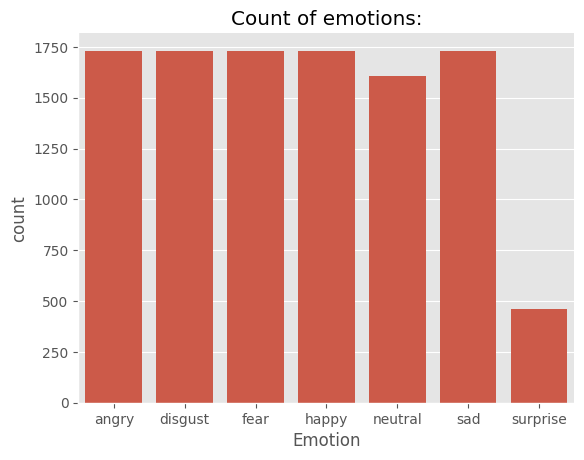

In [15]:
plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [16]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [17]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)

    librosa.display.waveshow(data, sr=sr)

    plt.show()


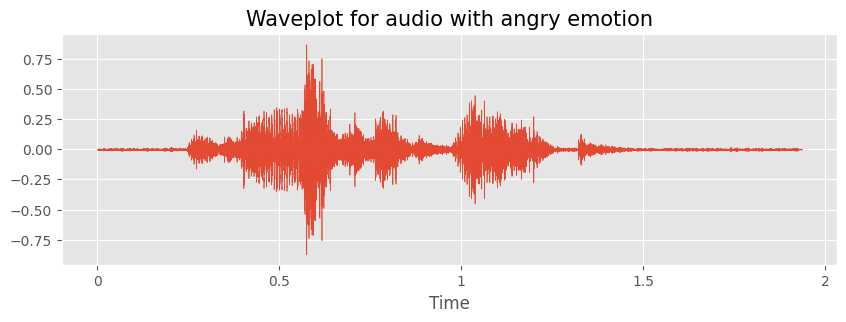

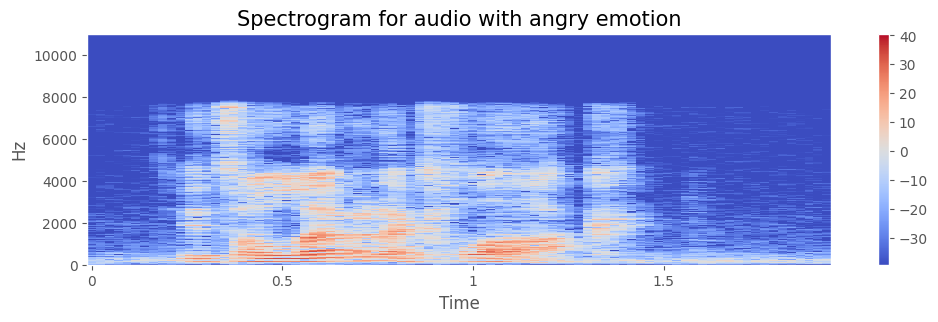

In [18]:
emotion='angry'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

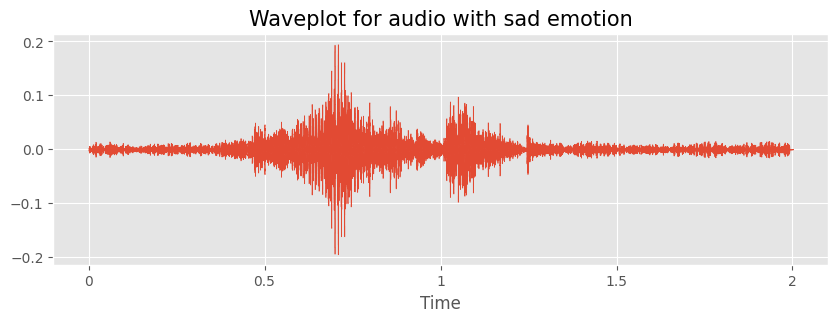

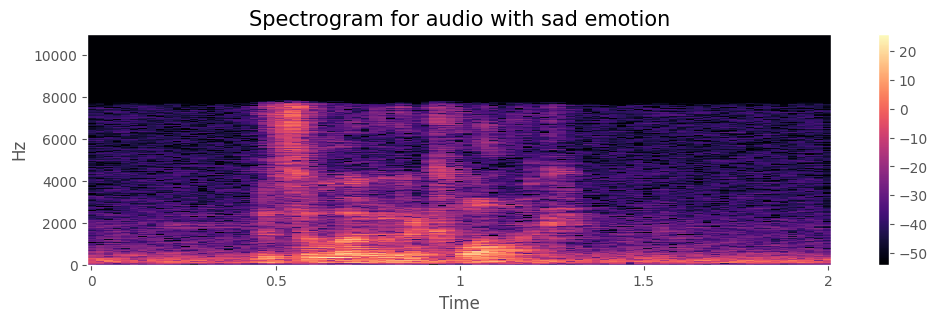

In [19]:
emotion='sad'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data augmentation

We have some ways for data augmentation in sound data:

1. Noise injection
2. Stretching
3. Shifting
4. Pitching

In [20]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [21]:
df.head()

,Emotion,Path
0,angry,ser-datasets\Crema/1001_DFA_ANG_XX.wav
1,disgust,ser-datasets\Crema/1001_DFA_DIS_XX.wav
2,fear,ser-datasets\Crema/1001_DFA_FEA_XX.wav
3,happy,ser-datasets\Crema/1001_DFA_HAP_XX.wav
4,neutral,ser-datasets\Crema/1001_DFA_NEU_XX.wav


In [22]:
path = df[df["Emotion"] == "happy"]["Path"].iloc[0]
data, sampling_rate = librosa.load(path)

1. Simple audio

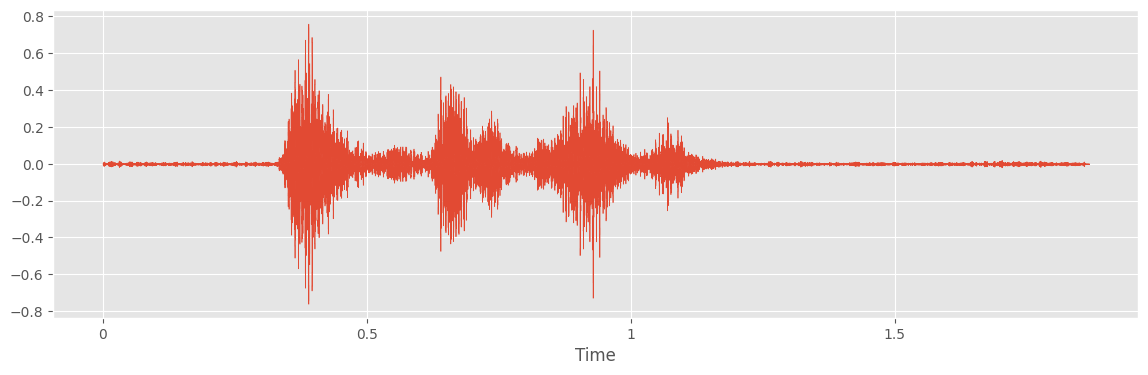

In [23]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

plt.figure(figsize=(14, 4))

librosa.display.waveshow(data, sr=sampling_rate)

plt.show()

Audio(path)


2. Noised audio

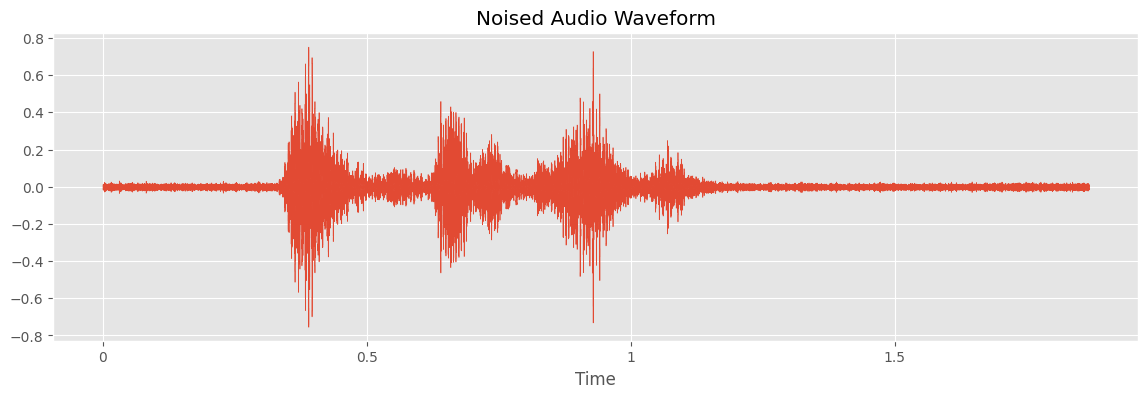

In [24]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

noised_data = noise(data, random=True)

plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=noised_data, sr=sampling_rate)
plt.title("Noised Audio Waveform")
plt.show()

Audio(noised_data, rate=sampling_rate)


3. Stretching


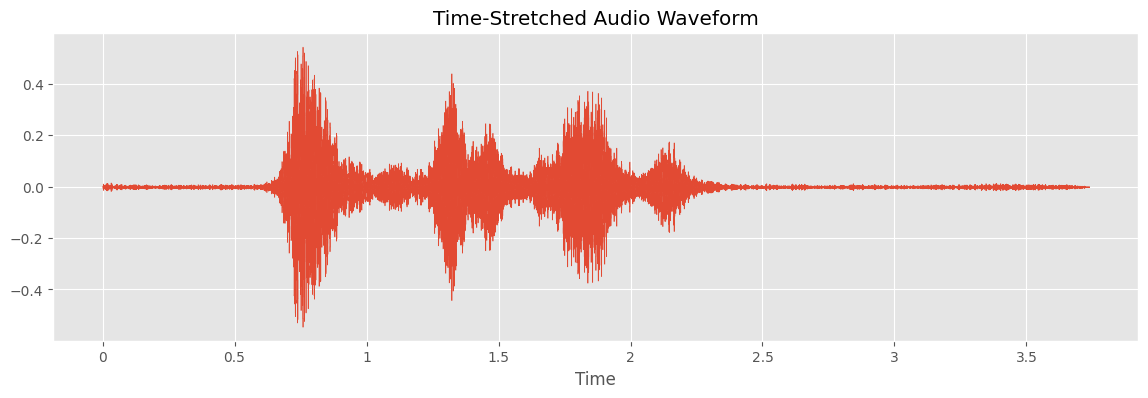

In [25]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

data = data.astype(np.float32)

stretched_data = librosa.effects.time_stretch(data, rate=0.5)

plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=stretched_data, sr=sampling_rate)
plt.title("Time-Stretched Audio Waveform")
plt.show()

Audio(stretched_data, rate=sampling_rate)


4. Shifting


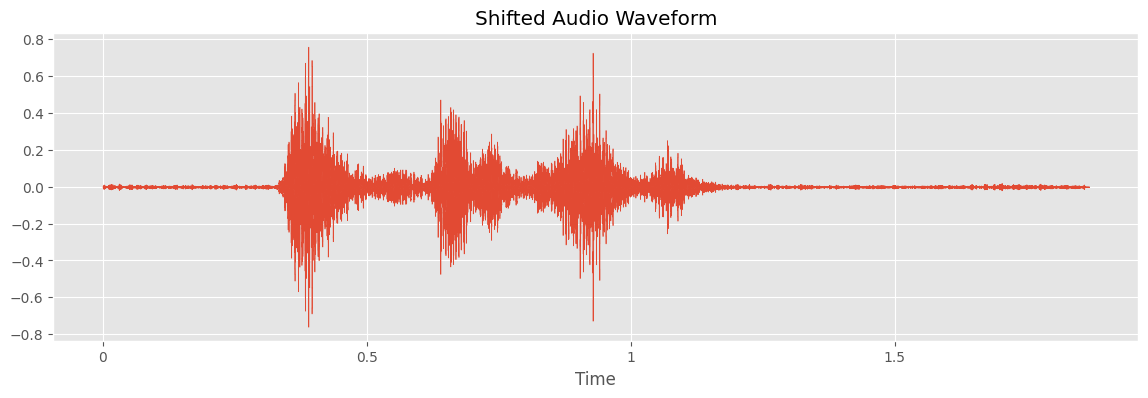

In [26]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

def shift(data, shift_max=2, shift_direction="both"):
    shift_amount = np.random.randint(-shift_max, shift_max)
    return np.roll(data, shift_amount)

shifted_data = shift(data)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=shifted_data, sr=sampling_rate)
plt.title("Shifted Audio Waveform")
plt.show()

Audio(shifted_data, rate=sampling_rate)


5. Pitching

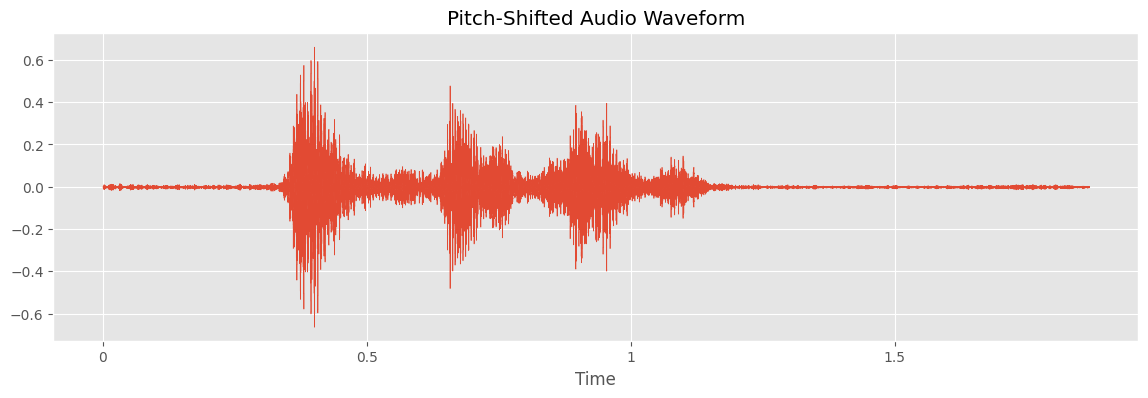

In [27]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

def pitch(data, sr, pitch_factor=0.5, random=False):
    if random:
        pitch_factor = np.random.uniform(-pitch_factor, pitch_factor)  # Randomize within range
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=pitch_factor)

pitched_data = pitch(data, sampling_rate, pitch_factor=2.0, random=True)  # Adjust pitch factor as needed

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=pitched_data, sr=sampling_rate)
plt.title("Pitch-Shifted Audio Waveform")
plt.show()

Audio(pitched_data, rate=sampling_rate)


For our data augmentation we will use noise and pitch and combination with both of it.


## Feature extraction

#### There are some features may be useful:

1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy :The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
3. Spectral Centroid : The center of gravity of the spectrum.
4. Spectral Spread : The second central moment of the spectrum.
5. Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
6. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
7. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
8. MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [28]:
n_fft = 2048
hop_length = 512

In [29]:
def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


# def spc_entropy(data, sr):
#     spc_en = spectral_entropy(data, sf=sr, method="fft")
#     return spc_en

def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

#### Let's check data formats:

In [30]:
path = np.array(df["Path"])[658]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

47101

In [31]:
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sampling_rate).shape)
# print("Spectral Entropy: ", spc_entropy(data, sampling_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sampling_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sampling_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sampling_rate).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)


ZCR:  (92,)
Energy:  (92,)
Entropy of Energy : (92,)
RMS : (92,)
Spectral Centroid : (92,)
Spectral Flux:  ()
Spectral Rollof:  (92,)
Chroma STFT:  (1104,)
MelSpectrogram:  (11776,)
MFCC:  (1840,)


In experimental way was decided to use just 3 main features for this task: *ZCR*, *RMS* and *MFCC*.

Also in experimental way  was decided to use just 2.5s duration with 0.6 offset - in the dataset first 0.6s contains
no information about emotion, and most of them are less then 3s.

In [32]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        # np.mean(energy(data, frame_length, hop_length),axis=0),
                        # np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        rmse(data, frame_length, hop_length),
                        # spc(data, sr, frame_length, hop_length),
                        # spc_entropy(data, sr),
                        # spc_flux(data),
                        # spc_rollof(data, sr, frame_length, hop_length),
                        # chroma_stft(data, sr, frame_length, hop_length),
                        # mel_spc(data, sr, frame_length, hop_length, flatten=True)
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [33]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result


In [34]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(df.Path, df.Emotion, range(df.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
2000 samples has been processed...
2100 samples has been processed...
2200 samples has been processed...
2300 samples has been processed...
2400 samples has been processed...
2500 samples has been processed...
2600 samples has been processed...
2700 samples has been processed...
2800 sampl

Let's save our features as DataFrame for further processing:

In [35]:
features_path = "./features.csv"

In [36]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.034180,0.069336,0.115723,0.148926,0.142090,0.130859,0.101562,0.070801,0.069336,0.074219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
1,0.054688,0.101562,0.165527,0.194824,0.178223,0.156250,0.109375,0.078613,0.081055,0.084961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
2,0.035156,0.071289,0.117188,0.146973,0.139648,0.127441,0.098633,0.070801,0.066895,0.074219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
3,0.159180,0.270508,0.366699,0.378906,0.317383,0.242676,0.179688,0.148926,0.189453,0.202637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
4,0.041504,0.059082,0.070312,0.062988,0.080566,0.128906,0.145508,0.146484,0.125977,0.072266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust


In [37]:
extracted_df = pd.read_csv(features_path)
print(extracted_df.shape)

(42888, 2377)


In [38]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape


0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(42888, 2377)

In [39]:
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.034180,0.069336,0.115723,0.148926,0.142090,0.130859,0.101562,0.070801,0.069336,0.074219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
1,0.054688,0.101562,0.165527,0.194824,0.178223,0.156250,0.109375,0.078613,0.081055,0.084961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
2,0.035156,0.071289,0.117188,0.146973,0.139648,0.127441,0.098633,0.070801,0.066895,0.074219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
3,0.159180,0.270508,0.366699,0.378906,0.317383,0.242676,0.179688,0.148926,0.189453,0.202637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
4,0.041504,0.059082,0.070312,0.062988,0.080566,0.128906,0.145508,0.146484,0.125977,0.072266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust


## Data preparation

As of now we have extracted the data, now we need to normalize and split our data for training and testing.


In [40]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

In [41]:
# Import the required modules
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels
lb = LabelEncoder()
Y = to_categorical(lb.fit_transform(Y))

# Print class labels
print(lb.classes_)
print(Y)


['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34310, 2376), (8578, 2376), (34310, 7), (8578, 7))

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((30879, 2376), (8578, 2376), (3431, 2376), (30879, 7), (8578, 7), (3431, 7))

In [44]:
# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((30879, 2376), (8578, 2376), (3431, 2376), (30879, 7), (8578, 7), (3431, 7))

In [45]:
# We have to use 1-dimensional CNN which need specifical shape:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(30879, 2376, 1)

### Let's define our model:

In [46]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)


In [47]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [48]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [49]:
model = models.Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(7, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc", f1_m])



c:\Users\nicol\Documents\School\emotion_detection\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2376, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2376, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1188, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1188, 512)      │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1188, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 594, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 594, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 297, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 297, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 297, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 149, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 149, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,915,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,193,223 (27.44 MB)

 Trainable params: 7,188,871 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [51]:
EPOCHS = 50
batch_size = 64

In [52]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load or create dataset (Replace with your actual data)
X = np.random.rand(100, 20)  # 100 samples, 20 features
y = np.random.randint(0, 5, 100)  # 100 labels, 5 classes

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure X_train is defined before accessing shape
if "X_train" not in locals():
    raise NameError("X_train is not defined!")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")


X_train shape: (80, 20)
y_train shape: (80,)
X_val shape: (20, 20)
y_val shape: (20,)


In [53]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

import tensorflow as tf
tf.keras.backend.clear_session()  


TensorFlow version: 2.18.0


In [54]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (80, 20)
y_train shape: (80,)
X_val shape: (20, 20)
y_val shape: (20,)


In [55]:
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)
print("X_val dtype:", X_val.dtype)
print("y_val dtype:", y_val.dtype)

X_train dtype: float64
y_train dtype: int32
X_val dtype: float64
y_val dtype: int32


In [57]:
print("y_train shape before reshape:", y_train.shape)
print("Total elements in y_train:", y_train.size)
print("Expected elements after reshape:", 80 * 7168)

print("Original y_train shape:", y_train.shape)

y_train.size == 80 * 7168

print("y_train shape before reshape:", y_train.shape)



y_train shape before reshape: (80,)
Total elements in y_train: 80
Expected elements after reshape: 573440
Original y_train shape: (80,)
y_train shape before reshape: (80,)


In [58]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2376, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2376, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1188, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1188, 512)      │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1188, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 594, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 594, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 297, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 297, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 297, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 149, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 149, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,915,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,193,223 (27.44 MB)

 Trainable params: 7,188,871 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [59]:
import tensorflow as tf
from tensorflow.keras import layers

class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = layers.Conv1D(512, 3, activation='relu')
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(7, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.flatten(x)
        output = self.dense1(x)
        return output  

In [ ]:
import tensorflow as tf
import numpy as np

# Create dummy data
X_dummy = np.random.rand(100, 2376, 1).astype('float32')
y_dummy = np.random.randint(0, 2, size=(100, 7168)).astype('float32')

# Create a simple model
model_dummy = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(2376, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7168, activation='sigmoid')
])

model_dummy.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Try fitting the dummy model
try:
    history_dummy = model_dummy.fit(X_dummy, y_dummy, epochs=5, batch_size=32)
    print("Dummy model fit successfully!")
except Exception as e:
    print("Dummy model fit failed:", e)

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 136s 34s/step - accuracy: 0.0000e+00 - loss: 0.7451
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 105s 23s/step - accuracy: 0.0000e+00 - loss: 0.7784
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 100s 24s/step - accuracy: 0.0000e+00 - loss: 0.6821
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 127s 33s/step - accuracy: 0.0000e+00 - loss: 0.6053
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 119s 29s/step - accuracy: 0.0000e+00 - loss: 0.5562
Dummy model fit successfully!


In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Initialize model
model = Sequential()

# Add input layer
model.add(Dense(64, activation='relu', input_shape=(20,)))  


In [80]:
print(f"y_train shape: {y_train.shape}")  # Should ideally be (samples, num_classes)
print("First 10 labels:", y_train[:10])   # Check if labels are integers or already one-hot

from tensorflow.keras.utils import to_categorical

NUM_CLASSES = len(set(y_train))  # Count unique classes

y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val = to_categorical(y_val, num_classes=NUM_CLASSES)

print(f"New y_train shape: {y_train.shape}")  # Should be (80, NUM_CLASSES)
print(f"New y_val shape: {y_val.shape}")  # Should be (validation_samples, NUM_CLASSES)

model = Sequential([
    Dense(64, activation='relu', input_shape=(20,)),  # Match X_train shape
    Dense(32, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')  # Use correct num_classes
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


y_train shape: (80,)
First 10 labels: [1 1 1 0 1 2 1 0 4 3]
New y_train shape: (80, 5)
New y_val shape: (20, 5)
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.1266 - loss: 1.6493 - val_accuracy: 0.1500 - val_loss: 1.6657
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1461 - loss: 1.6197 - val_accuracy: 0.2000 - val_loss: 1.6759
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2711 - loss: 1.5887 - val_accuracy: 0.1500 - val_loss: 1.6913
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3359 - loss: 1.5695 - val_accuracy: 0.1500 - val_loss: 1.7084
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2953 - loss: 1.5596 - val_accuracy: 0.1500 - val_loss: 1.7269
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3445 - loss: 1.5236 - val_accuracy: 0.1500 - val_loss: 1.7455
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3641 - loss: 1.5135 - val_accuracy: 0.1500 - val_loss: 1.7599
Epoch 8/10
3

In [88]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(2376,)),  # Match X_test shape
    Dense(32, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])


In [89]:
y_check = np.argmax(y_test, axis=1)
y_check

array([1, 5, 6, ..., 4, 4, 0], dtype=int64)

In [91]:
# Ensure you have y_pred from the model
y_pred = model.predict(X_test)  # Predict on the test set
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels (if using softmax)

# Define the true labels (y_check should be your ground truth labels)
y_check = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded; if not, skip this step

# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

# Print the confusion matrix
print(cm)


269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[ 82 543 504  95 148   0   0]
 [ 91 465 572  71 206   0   0]
 [ 90 486 529  56 136   0   0]
 [ 76 564 625  81  88   0   0]
 [ 62 457 558  79 122   0   0]
 [ 63 559 567  77 169   0   0]
 [ 16 126 154  42  19   0   0]]


In [92]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 82 543 504  95 148   0   0]
 [ 91 465 572  71 206   0   0]
 [ 90 486 529  56 136   0   0]
 [ 76 564 625  81  88   0   0]
 [ 62 457 558  79 122   0   0]
 [ 63 559 567  77 169   0   0]
 [ 16 126 154  42  19   0   0]]


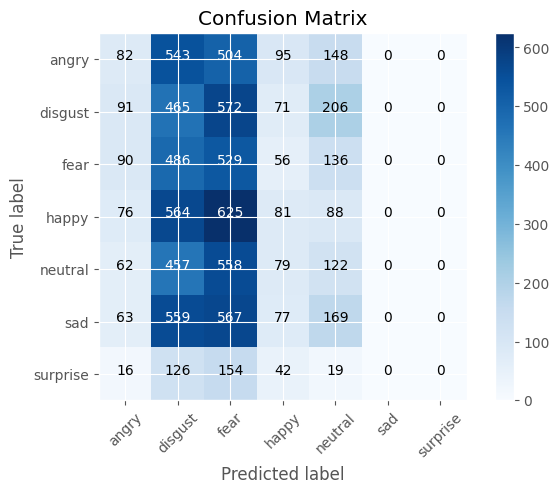

In [93]:
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [94]:
path_to_model = "./res_model.h5"

model.save(path_to_model)